In [51]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
from datetime import datetime, date, timedelta

# statistical analysis
import statsmodels.api as sm
from statsmodels import regression

import yfinance as yfin
yfin.pdr_override()

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

#from var import VaR

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')
sns.set_theme(rc={'axes.formatter.limits': (-8, 9)})
style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = (10,6)

# Weekly Tasks
Prepare a presentation using Panopto (PowerPoint slides with Video Narration is an acceptable alternative) addressing the following points:
What scenario were you assigned as the result of the random number exercise?

- What were your considerations in determining an appropriate investment strategy for that scenario?

- What asset allocation did you implement that you felt best supported that investment strategy?

- What assets did you invest in consistent with that asset allocation and strategy? (Assets, Price at time of investment, % of total investment)

- Present Value, Profit/Loss to date, VaR, SHARPE, VWAP, Alpha (Other metrics that you feel important in support of your strategy) for your portfolio 

What reallocation of assets would you recommend at this time (if any) and why?
Post your presentation accessible to your colleagues for comment and comment on the presentations by your colleagues.

# Variables

In [52]:
start_date = datetime(2022, 1, 1)
purchase_date = datetime(2023, 9, 11)
purchase_date_str = '2023-9-11'
end_date = datetime.now()
end_date_str = end_date.strftime("%Y-%m-%d")

alpha = 0.05
period = '5y'

# Functions

In [53]:
def alpha(portfolio_returns, benchmark_returns):
    # mean of the return
    portfolio_avg_return = np.mean(portfolio_returns)
    benchmark_avg_return = np.mean(benchmark_returns)
    
    # volatility
    portfolio_volatility = np.std(portfolio_returns)
    benchmark_volatility = np.std(benchmark_returns)
    
    # our alpha
    alpha = (portfolio_avg_return - benchmark_avg_return) / (portfolio_volatility / benchmark_volatility)
    
    return alpha


def linreg(x,y):
    x = sm.add_constant(x) # add a column of 1s to our data (for intercept)
    model = regression.linear_model.OLS(y,x).fit()
    x = x[:, 1] # remove the constant
    return model.params[0], model.params[1]

# Load Data

## Load Variables

In [100]:
var_lst = ['SPY']
bench_df = pdr.get_data_yahoo(var_lst, start=purchase_date, end=end_date)['Close']
#bench_df = round((bench_df.mean() / 100),4)
bench_econ_df = pd.DataFrame(bench_df)
bench_econ_df.columns = ['SPY']

benchPercent_econ_df = bench_econ_df.pct_change()[1:]
benchPercent_econ_df.reset_index(inplace=True)
benchPercent_econ_df.head()

[*********************100%%**********************]  1 of 1 completed


,Date,SPY
0,2023-09-12,-0.0055
1,2023-09-13,0.0012
2,2023-09-14,0.0086
3,2023-09-15,-0.0155
4,2023-09-18,0.0006


In [101]:
var_lst = ['FHNFX']
bench_df = pdr.get_data_yahoo(var_lst, start=purchase_date, end=end_date)['Close']
#bench_df = round((bench_df.mean() / 100),4)
bench_int_df = pd.DataFrame(bench_df)
bench_int_df.columns = ['FHNFX']

benchPercent_int_df = bench_int_df.pct_change()[1:]
benchPercent_int_df.reset_index(inplace=True)
benchPercent_int_df.head()

[*********************100%%**********************]  1 of 1 completed


,Date,FHNFX
0,2023-09-12,0.0000
1,2023-09-13,0.0011
2,2023-09-14,-0.0022
3,2023-09-15,-0.0022
4,2023-09-18,0.0011


## Graph Porfolio Values

In [78]:
folioValue_df[folioValue_df['Date'] == purchase_date.strftime("%Y-%m-%d")]

,Date,share_value,pct_change
0,2023-09-11,"83,718,683.5760",NaN


In [79]:
#
m1_df = folioValue_df.merge(benchPercent_df, how='outer', left_on='Date', right_on='Date')
#m1_df = m1_df.melt(id_vars=['Date'])
m1_df

,Date,share_value,pct_change,SPY
0,2023-09-11,"83,718,683.5760",NaN,NaN
1,2023-09-12,"83,597,204.6712",NaN,-0.0055
2,2023-09-13,"83,425,622.0770",NaN,0.0012
3,2023-09-14,"83,951,847.4157",0.0000,0.0086
4,2023-09-15,"83,535,984.2190",-0.0027,-0.0155
5,2023-09-18,"83,385,738.9465",0.0004,0.0006
6,2023-09-19,"83,125,551.4857",0.0000,-0.0021
7,2023-09-20,"82,731,603.7352",-0.0040,-0.0092
8,2023-09-21,"81,637,046.9092",0.0010,-0.0165
9,2023-09-22,"81,608,403.5950",0.0000,-0.0022


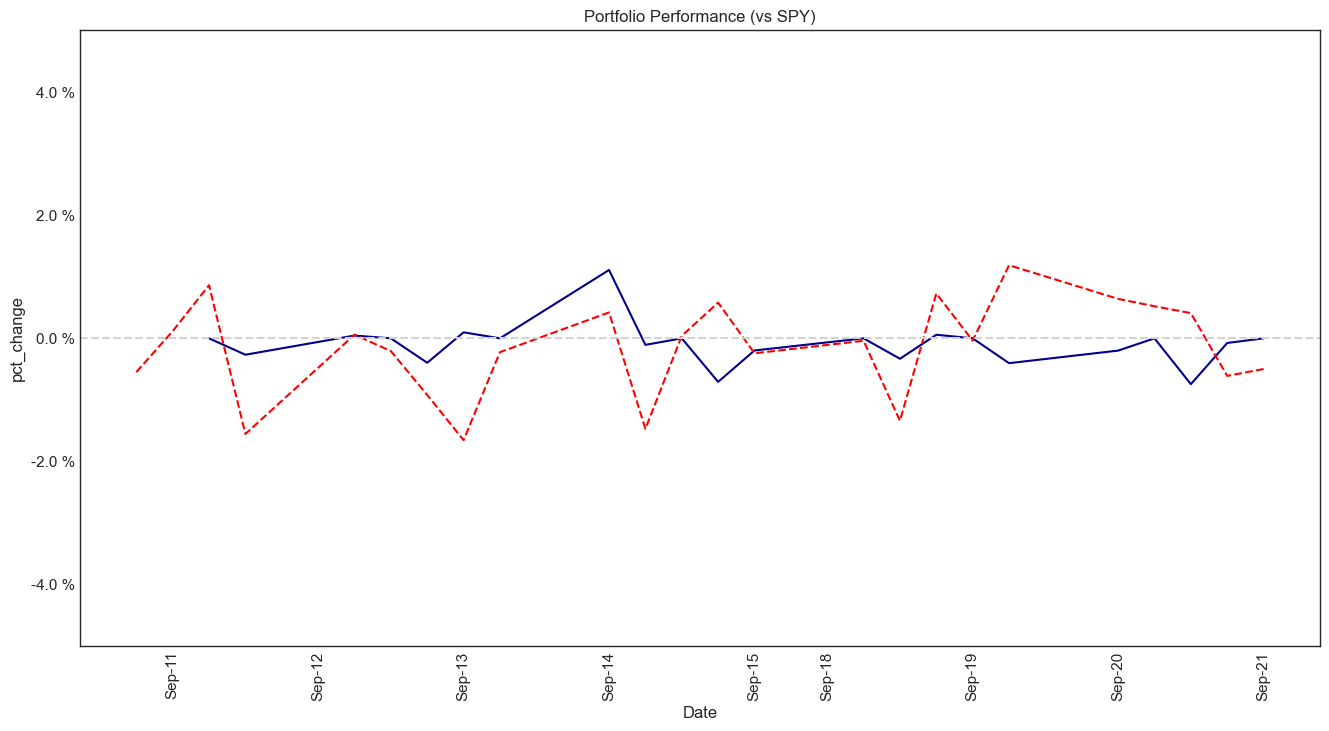

In [99]:
# Graph
fig, ax = plt.subplots(figsize=(16,8))
plt.ticklabel_format(style='plain', axis='y')

ax.set_ylim(-.05, 0.05)
ax.tick_params(axis='x', labelrotation=90) 
xticks = xticks = m1_df['Date'].tolist()
ax.set_xticklabels([pd.to_datetime(tm, unit='d').strftime('%b-%d') for tm in xticks])

# Plot
sns.set_style("white")
g = sns.lineplot(data=m1_df, x="Date", y="pct_change", color='darkblue')
g = sns.lineplot(data=m1_df, x="Date", y="SPY", color='red', linestyle="dashed")
#ax = sns.lineplot(x=x, y=y, linestyle="dashed")
g.set_yticklabels(['{:,.1f}'.format(x) + ' %' for x in g.get_yticks() * 100])

plt.axhline(y=0, linestyle="dashed", color='lightgray')

ax.set(title='Portfolio Performance (vs SPY)');

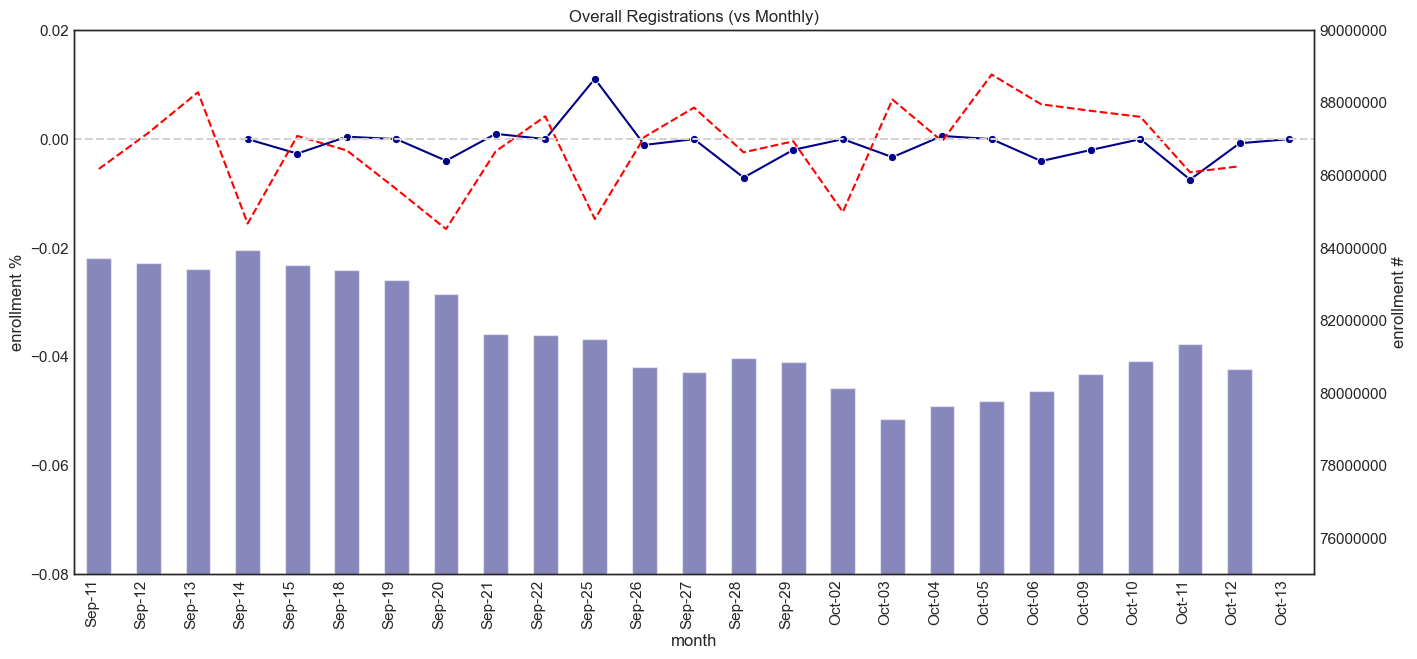

In [102]:
fig, ax1 = plt.subplots(figsize=(16,8))
sns.lineplot(data = m1_df['pct_change'], marker='o' ,color='darkblue',sort=False, ax=ax1)
sns.lineplot(data = benchPercent_econ_df['SPY'], color='red' , linestyle="dashed" ,sort=False, ax=ax1)
plt.axhline(y=0, linestyle="dashed", color='lightgray')

ax2 = ax1.twinx()
sns.barplot(data = m1_df, x='Date', y='share_value', alpha=0.5, ax=ax2, color='darkblue', width=.5)

ax1.set_ylim(-.08, 0.02)
ax2.set_ylim(75000000, 90000000)

fig.autofmt_xdate()
ax1.tick_params(axis='x', labelrotation=90) 
xticks = xticks = m1_df['Date'].tolist()
ax2.set_xticklabels([pd.to_datetime(tm, unit='d').strftime('%b-%d') for tm in xticks])

# annotations
ax1.set_title('Overall Registrations (vs Monthly)')
ax1.set(xlabel='month', ylabel='enrollment %')
ax2.set(ylabel='enrollment #')

plt.show()

In [82]:
#
m2_df = folioValue_df.merge(benchPercent_df, how='outer', left_on='Date', right_on='Date')
#m1_df = m1_df.melt(id_vars=['Date'])
m2_df.head()

,Date,share_value,pct_change,SPY
0,2023-09-11,"83,718,683.5760",NaN,NaN
1,2023-09-12,"83,597,204.6712",NaN,-0.0055
2,2023-09-13,"83,425,622.0770",NaN,0.0012
3,2023-09-14,"83,951,847.4157",0.0000,0.0086
4,2023-09-15,"83,535,984.2190",-0.0027,-0.0155


In [106]:
t_df = fv_df[fv_df['Class'] == 'Economically Sensitive']
t_df.head()

,Date,Class,share_value,pct_change
1,2023-09-11,Economically Sensitive,"50,535,872.6588",NaN
4,2023-09-12,Economically Sensitive,"50,401,357.6570",-0.0027
7,2023-09-13,Economically Sensitive,"50,201,477.5737",-0.0040
10,2023-09-14,Economically Sensitive,"50,758,492.1692",0.0111
13,2023-09-15,Economically Sensitive,"50,399,819.5650",-0.0071


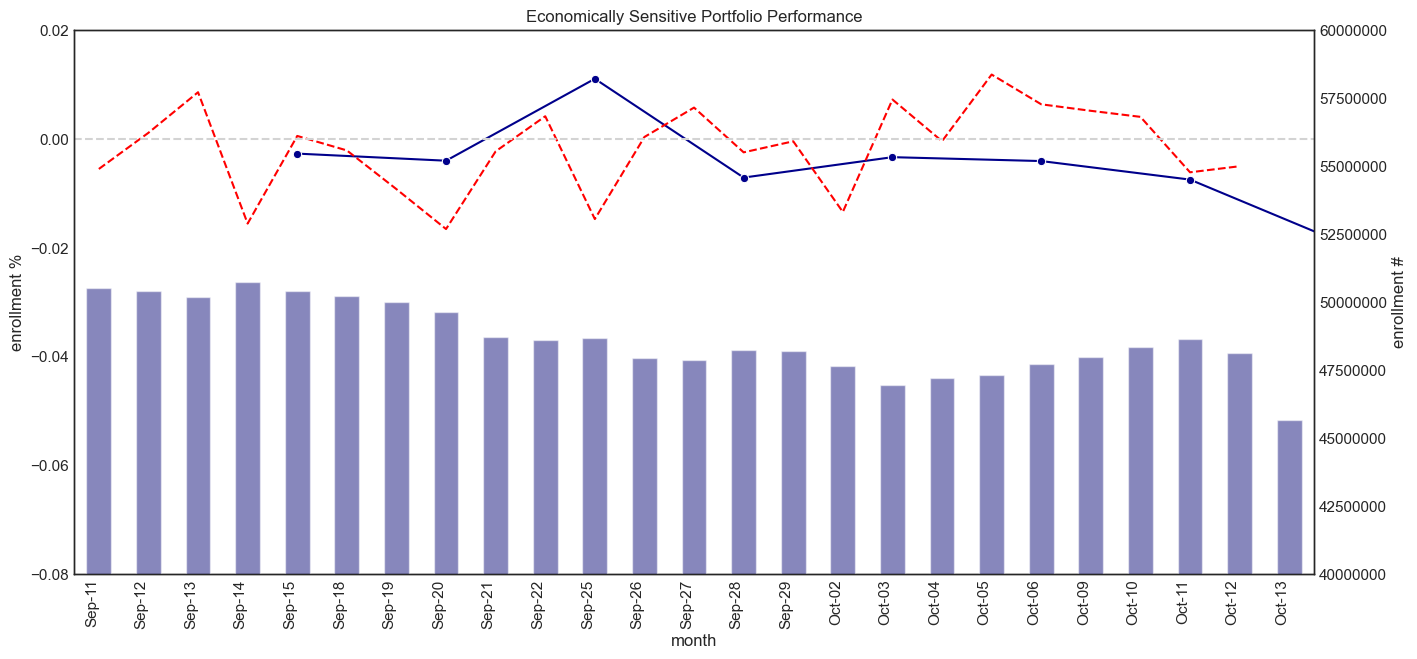

In [107]:
fig, ax1 = plt.subplots(figsize=(16,8))
sns.lineplot(data = t_df['pct_change'], marker='o' ,color='darkblue',sort=False, ax=ax1)
sns.lineplot(data = benchPercent_econ_df['SPY'], color='red' , linestyle="dashed" ,sort=False, ax=ax1)
plt.axhline(y=0, linestyle="dashed", color='lightgray')

ax2 = ax1.twinx()
#sns.barplot(data = m1_df, x='Date', y='share_value', alpha=0.5, ax=ax2, color='darkblue', width=.5)
sns.barplot(data = t_df, x='Date', y='share_value',errorbar=None,alpha=0.5, ax=ax2, color='darkblue', width=.5)

ax1.set_ylim(-.08, 0.02)
ax2.set_ylim(40000000, 60000000)

fig.autofmt_xdate()
ax1.tick_params(axis='x', labelrotation=90) 
xticks = xticks = m1_df['Date'].tolist()
ax2.set_xticklabels([pd.to_datetime(tm, unit='d').strftime('%b-%d') for tm in xticks])

# annotations
ax1.set_title('Economically Sensitive Portfolio Performance')
ax1.set(xlabel='month', ylabel='enrollment %')
ax2.set(ylabel='enrollment #')

plt.show()

In [104]:
t_df = fv_df[fv_df['Class'] == 'Interest Rate Sensitive']
t_df.head()

,Date,Class,share_value,pct_change
2,2023-09-11,Interest Rate Sensitive,"28,999,954.9171",NaN
5,2023-09-12,Interest Rate Sensitive,"29,012,991.0141",0.0004
8,2023-09-13,Interest Rate Sensitive,"29,041,288.5032",0.0010
11,2023-09-14,Interest Rate Sensitive,"29,010,499.2465",-0.0011
14,2023-09-15,Interest Rate Sensitive,"28,953,308.6540",-0.0020


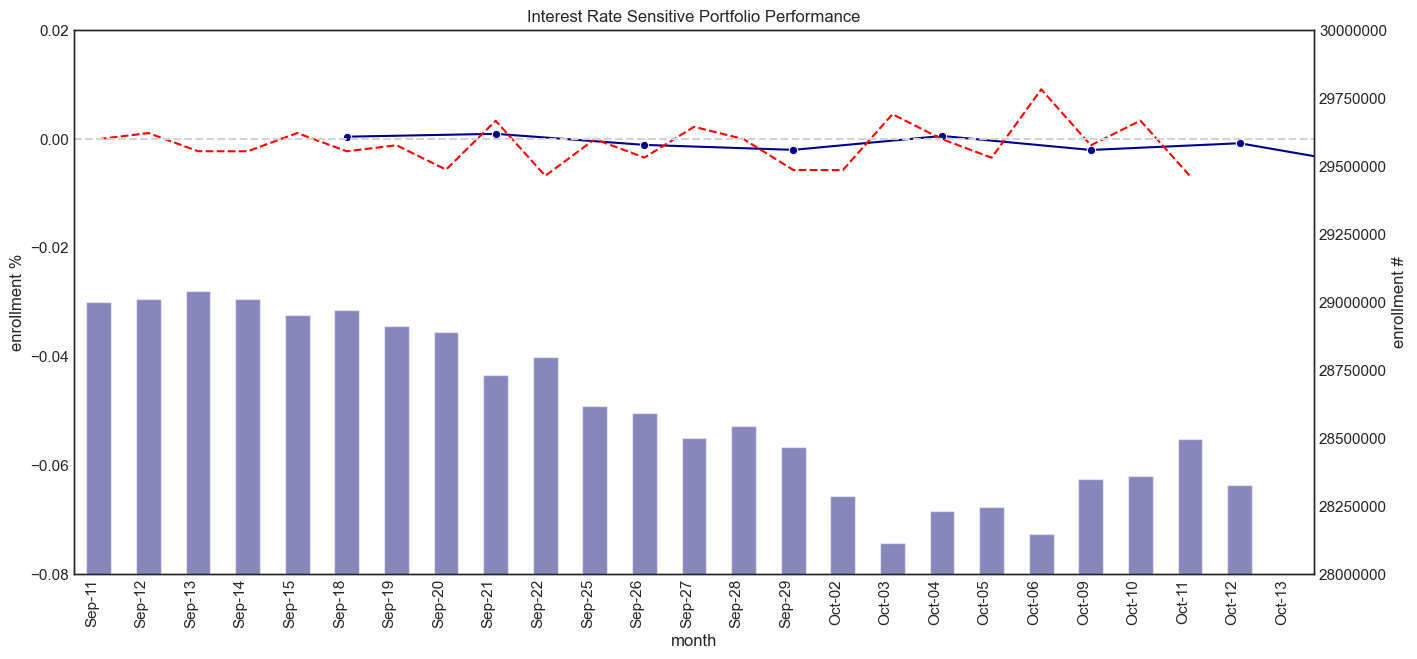

In [105]:
fig, ax1 = plt.subplots(figsize=(16,8))
sns.lineplot(data = t_df['pct_change'], marker='o' ,color='darkblue',sort=False, ax=ax1)
sns.lineplot(data = benchPercent_int_df['FHNFX'], color='red' , linestyle="dashed" ,sort=False, ax=ax1)
plt.axhline(y=0, linestyle="dashed", color='lightgray')

ax2 = ax1.twinx()
#sns.barplot(data = m1_df, x='Date', y='share_value', alpha=0.5, ax=ax2, color='darkblue', width=.5)
sns.barplot(data = t_df, x='Date', y='share_value',errorbar=None,alpha=0.5, ax=ax2, color='darkblue', width=.5)

ax1.set_ylim(-.08, 0.02)
ax2.set_ylim(28000000, 30000000)

fig.autofmt_xdate()
ax1.tick_params(axis='x', labelrotation=90) 
xticks = xticks = m1_df['Date'].tolist()
ax2.set_xticklabels([pd.to_datetime(tm, unit='d').strftime('%b-%d') for tm in xticks])

# annotations
ax1.set_title('Interest Rate Sensitive Portfolio Performance')
ax1.set(xlabel='month', ylabel='enrollment %')
ax2.set(ylabel='enrollment #')

plt.show()

# Alpha Calculations

# Economically Sensitive

In [87]:
tickers='^DJA'
#tickers = 'FHNFX'
bench_data = pdr.get_data_yahoo(tickers=tickers, start=purchase_date, end=end_date )
bench_econ_df= pd.DataFrame(bench_data['Close'])
bench_econ_df.columns = ['bench']
bench_econ_df['precent_bench']= bench_econ_df['bench'].pct_change(1)

print('bench_econ_df:', bench_econ_df.shape)
#bench_econ_df

[*********************100%%**********************]  1 of 1 completed
bench_econ_df: (25, 2)


In [88]:
ticker_lst = folio_econ_df['Ticker']
print('ticker_lst:', len(ticker_lst))

#value_econ_df = merge_df[merge_df['Ticker'].isin(ticker_lst)]
#print('value_econ_df:', value_econ_df.shape)

ticker_lst: 20


In [89]:
bench_econ_df

,bench,precent_bench
Date,,
2023-09-11,"11,507.4902",NaN
2023-09-12,"11,487.9102",-0.0017
2023-09-13,"11,495.8398",0.0007
2023-09-14,"11,610.8398",0.0100
2023-09-15,"11,537.9004",-0.0063
2023-09-18,"11,518.4697",-0.0017
2023-09-19,"11,470.0400",-0.0042
2023-09-20,"11,457.0400",-0.0011
2023-09-21,"11,341.3398",-0.0101


In [90]:
alpha_econ_df = pd.DataFrame(columns=['Ticker','alpha','beta'])

for t in ticker_lst:
    X = bench_econ_df['precent_bench'].values
    y = merge_df[merge_df['Ticker'] == t]['perc_share_value'].values
    
    t_df = pd.DataFrame({'X':X,'y':y})
    t_df = t_df[np.isfinite(t_df).all(1)]
    
    alpha, beta = linreg(t_df.X.values,t_df.y.values)
    alpha_econ_df.loc[len(alpha_econ_df.index)] = [t, alpha, beta]
    
print('alpha_econ_df:', alpha_econ_df.shape)

alpha_econ_df: (20, 3)


## Graph

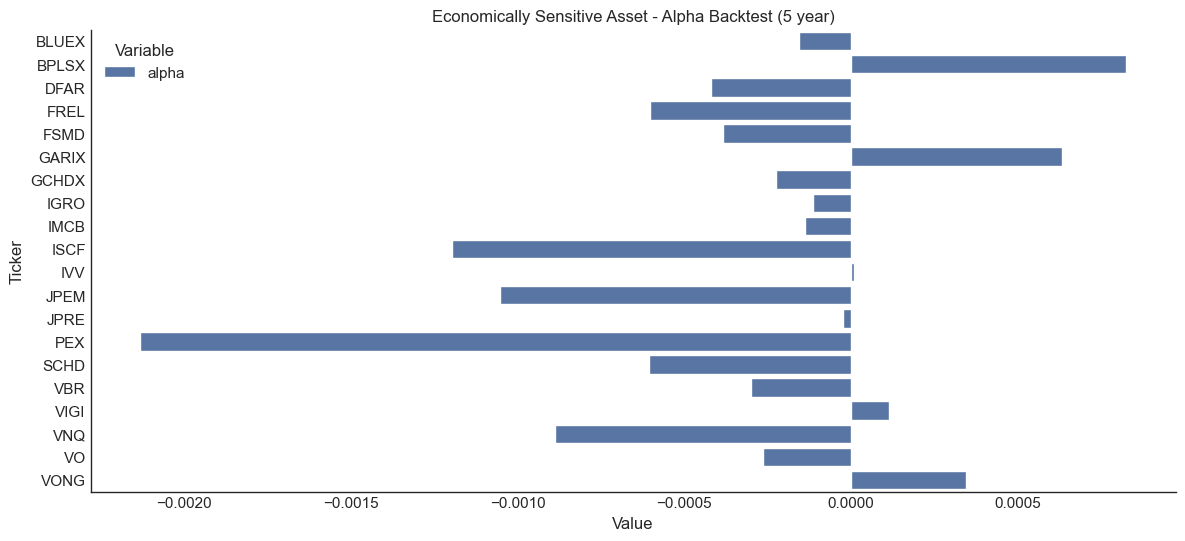

In [91]:
fig, ax = plt.subplots(figsize=(14,6))
t_df = alpha_econ_df.melt(id_vars='Ticker').rename(columns=str.title)
t_df = t_df[t_df['Variable'] == 'alpha']
g = sns.barplot(x='Value', y='Ticker', hue='Variable',data=t_df, ax=ax)
sns.despine(fig)
ax.set(title='Economically Sensitive Asset - Alpha Backtest (5 year)');

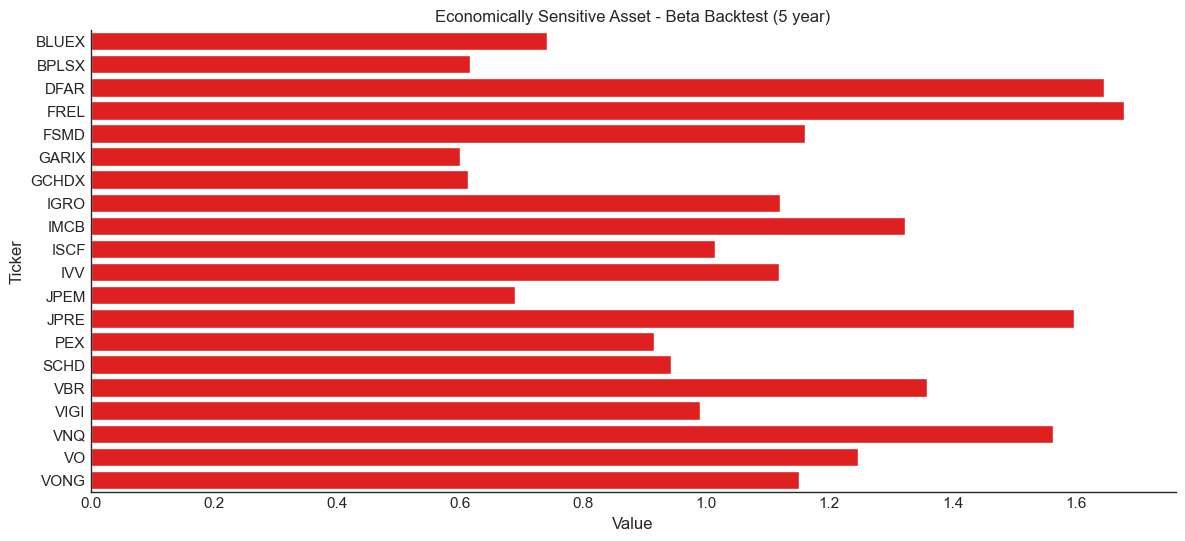

In [92]:
fig, ax = plt.subplots(figsize=(14,6))
t_df = alpha_econ_df.melt(id_vars='Ticker').rename(columns=str.title)
t_df = t_df[t_df['Variable'] == 'beta']
g = sns.barplot(x='Value', y='Ticker', color='red', data=t_df, ax=ax)
sns.despine(fig)
ax.set(title='Economically Sensitive Asset - Beta Backtest (5 year)');

# Interest Rate Sensitive

In [93]:
#tickers='^DJA'
tickers = 'FHNFX'
bench_data = pdr.get_data_yahoo(tickers=tickers, start=purchase_date, end=end_date )
bench_int_df= pd.DataFrame(bench_data['Close'])
bench_int_df.columns = ['bench']
bench_int_df['precent_bench']= bench_int_df['bench'].pct_change(1)

print('bench_int_df #:', bench_int_df.shape)
lb = len(bench_int_df)

[*********************100%%**********************]  1 of 1 completed
bench_int_df #: (24, 2)


In [94]:
ticker_lst = folio_int_df['Ticker']
print('ticker_lst:', len(ticker_lst))

ticker_lst: 14


In [95]:
alpha_int_df = pd.DataFrame(columns=['Ticker','alpha','beta'])

for t in ticker_lst:
    X = bench_int_df['precent_bench'].values
    y = merge_df[merge_df['Ticker'] == t][:lb]['perc_share_value'].values
    
    t_df = pd.DataFrame({'X':X,'y':y})
    t_df = t_df[np.isfinite(t_df).all(1)]
    
    alpha, beta = linreg(t_df.X.values,t_df.y.values)
    alpha_int_df.loc[len(alpha_int_df.index)] = [t, alpha, beta]
    
print('alpha_int_df:', alpha_int_df.shape)

alpha_int_df: (14, 3)


## Graph

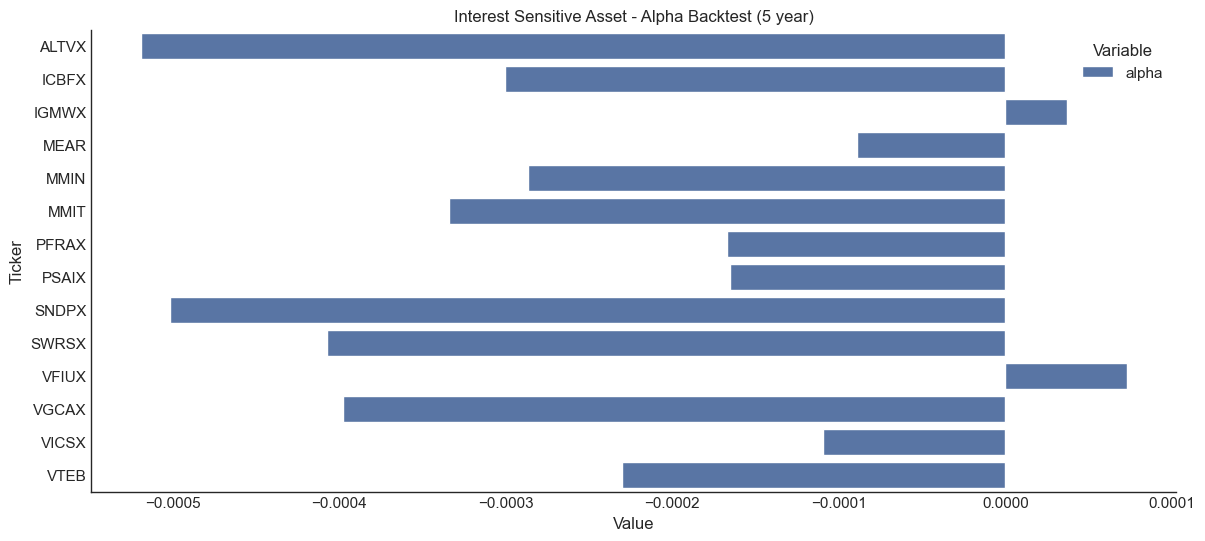

In [96]:
fig, ax = plt.subplots(figsize=(14,6))
t_df = alpha_int_df.melt(id_vars='Ticker').rename(columns=str.title)
t_df = t_df[t_df['Variable'] == 'alpha']
g = sns.barplot(x='Value', y='Ticker', hue='Variable',data=t_df, ax=ax)
sns.despine(fig)
ax.set(title='Interest Sensitive Asset - Alpha Backtest (5 year)');

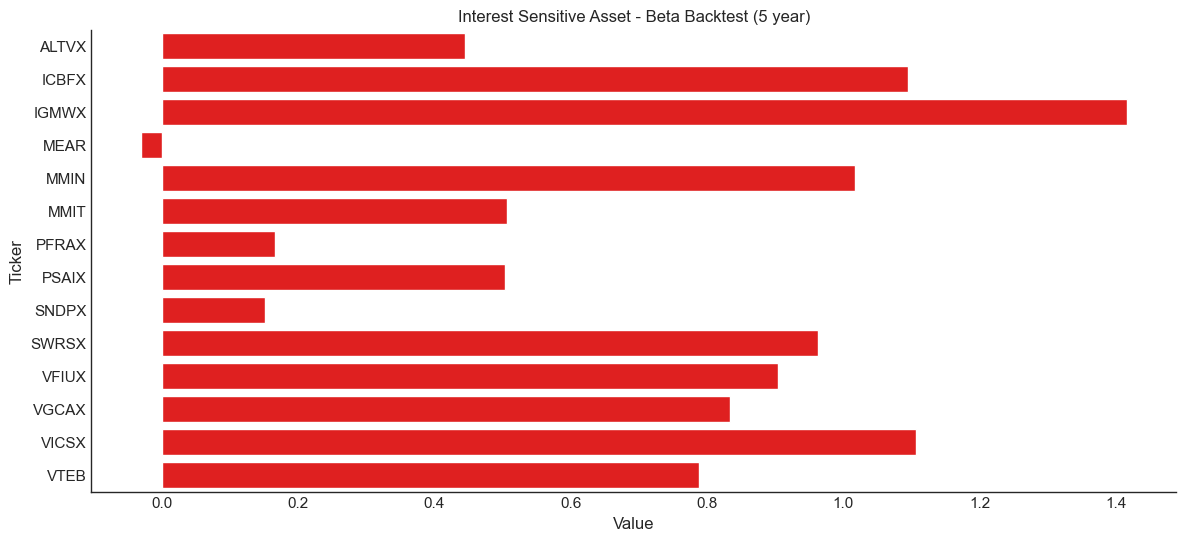

In [97]:
fig, ax = plt.subplots(figsize=(14,6))
t_df = alpha_int_df.melt(id_vars='Ticker').rename(columns=str.title)
t_df = t_df[t_df['Variable'] == 'beta']
g = sns.barplot(x='Value', y='Ticker', color='red',data=t_df, ax=ax)
sns.despine(fig)
ax.set(title='Interest Sensitive Asset - Beta Backtest (5 year)');